In [1]:
import os
import numpy as np
import cv2
from scipy.interpolate import RectBivariateSpline
from skimage.filters import apply_hysteresis_threshold
import matplotlib.pyplot as plt

In [2]:
def lucas_kanade_affine(img1, img2, p, Gx, Gy):
    ### START CODE HERE ###
    # [Caution] From now on, you can only use numpy and 
    # RectBivariateSpline. Never use OpenCV.

    converging_rate = 100
    
    W = p.reshape(3,2).transpose() + np.array([[1,0,0],[0,1,0]])
    h, w = img2.shape

    img2_warp = np.zeros((h, w))
    Gx_warp   = np.zeros((h, w))
    Gy_warp   = np.zeros((h, w))
    
    img2_spline = RectBivariateSpline(np.arange(h), np.arange(w), img2)
    Gx_spline   = RectBivariateSpline(np.arange(h), np.arange(w), Gx)
    Gy_spline   = RectBivariateSpline(np.arange(h), np.arange(w), Gy)
    
    for i in range(h):
        for j in range(w):
            x, y = np.dot(W, np.array([j, i, 1]))
            if (0 <= x < w) and (0 <= y < h):
                img2_warp[i, j] = img2_spline.ev(y, x)
                Gx_warp[i, j]   =   Gx_spline.ev(y, x)
                Gy_warp[i, j]   =   Gy_spline.ev(y, x)
            else:
                img2_warp[i, j] = img1[i, j]
                Gx_warp[i, j]   = 0
                Gy_warp[i, j]   = 0
                
    error_image = (img1 - img2_warp).reshape(-1, 1)
    
    gradient = np.hstack((Gx.reshape(-1, 1), Gy.reshape(-1, 1)))
    steepest_descent = np.zeros((w*h, 6))
    for x in range(w):
        for y in range(h):
            jacobian = np.array([[x, 0, y, 0, 1, 0], [0, x, 0, y, 0, 1]])
            steepest_descent[w*y + x] = gradient[w*y + x] @ jacobian

    hessian = steepest_descent.T @ steepest_descent
    hessian_inv = np.linalg.inv(hessian)
    
    dp = hessian_inv @ steepest_descent.T @ error_image
    dp = dp.flatten() * converging_rate
    
    ### END CODE HERE ###
    return dp


In [3]:
def subtract_dominant_motion(img1, img2):
    Gx = cv2.Sobel(I, cv2.CV_64F, 1, 0, ksize = 5) # do not modify this
    Gy = cv2.Sobel(I, cv2.CV_64F, 0, 1, ksize = 5) # do not modify this
    
    ### START CODE HERE ###
    # [Caution] From now on, you can only use numpy and 
    # RectBivariateSpline. Never use OpenCV.
    global p
    epsilon = 1.0
    
    while True:
        dp = lucas_kanade_affine(img1, img2, p, Gx, Gy)
        p += dp
        if np.linalg.norm(dp) < epsilon:
            break
            
    W = p.reshape(3,2).transpose() + np.array([[1,0,0],[0,1,0]])

    h, w = img2.shape
    img2_spline = RectBivariateSpline(np.arange(h), np.arange(w), img2)
    
    img_warp = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            x, y = np.dot(W, np.array([j, i, 1]))
            if (0 <= x < w) and (0 <= y < h):
                img_warp[i, j] = img2_spline.ev(y, x)
            else:
                img_warp[i, j] = img1[i, j]

    moving_image = np.abs(img1 - img_warp)
    
    th_hi = 0.2 * 256 # you can modify this
    th_lo = 0.15 * 256 # you can modify this
    
    ### END CODE HERE ###

    hyst = apply_hysteresis_threshold(moving_image, th_lo, th_hi)
    return hyst

In [4]:
data_dir = 'data'
# video_path = 'motion.mp4'
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(video_path, fourcc, 150/20, (636, 318))
tmp_path = os.path.join(data_dir, "organized-{}.jpg".format(0))
T = cv2.cvtColor(cv2.imread(tmp_path), cv2.COLOR_BGR2GRAY)

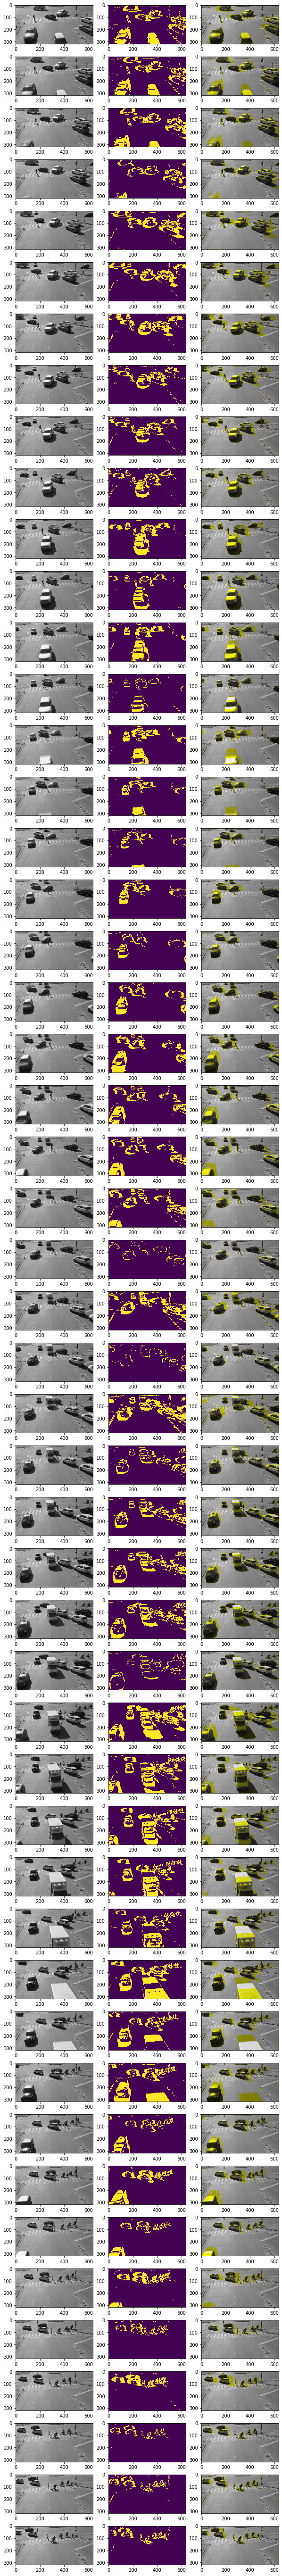

In [9]:
p = np.zeros(6)
frame = 50
_, axes = plt.subplots(ncols=3, nrows=frame, figsize=(10, 2*frame))
for i in range(0, frame):
    img_path = os.path.join(data_dir, "organized-{}.jpg".format(i))
    I = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    clone = I.copy()
    moving_img = subtract_dominant_motion(T, I)
    clone = cv2.cvtColor(clone, cv2.COLOR_GRAY2BGR)
    axes[i,0].imshow(clone)
    axes[i,1].imshow(moving_img)
    clone[moving_img, 2] = 522
    axes[i,2].imshow(clone)
#     out.write(clone)
    T = I
# out.release()